In [15]:
%%capture

!pip install open_clip_torch
!pip install -r requirements.txt
!pip install -r requirements1.txt
!pip install -r requirements2.txt

In [16]:
import os
import json
import torch
import pandas as pd
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import open_clip
from transformers import get_scheduler
from torchvision.transforms import RandAugment
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
data_dir = "./facebook-hateful-memes-dataset"
images_dir = data_dir
train_path = os.path.join(data_dir, "train.jsonl")
dev_path = os.path.join(data_dir, "dev.jsonl")

### Dataset Preparation

In [18]:
class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.samples = []
        with open(jsonl_path, "r") as f:
            for line in f:
                data = json.loads(line)
                img_path = os.path.join(img_dir, data["img"])
                text = data["text"]
                label = data.get("label")
                if label is not None:
                    label = float(label)
                sample_id = data.get("id")
                self.samples.append({"image": img_path, "text": text, "label": label, "id": sample_id})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image = Image.open(entry["image"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, entry["text"], entry["label"], entry["id"]

In [19]:
model_clip, _, _ = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_image_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(clip_image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

val_transform = transforms.Compose([
    transforms.Resize(clip_image_size),
    transforms.CenterCrop(clip_image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

train_dataset = HatefulMemesDataset(train_path, images_dir, transform=train_transform)
val_dataset = HatefulMemesDataset(dev_path, images_dir, transform=val_transform)

tokenizer = open_clip.get_tokenizer("ViT-B-32")

def collate_fn(batch):
    imgs, texts, labels, ids = zip(*batch)
    imgs = torch.stack(imgs)
    text_tokens = tokenizer(list(texts))
    labels_tensor = None if labels[0] is None else torch.tensor(labels, dtype=torch.float32)
    return imgs, text_tokens, labels_tensor, list(ids)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate_fn)

### Model Initialization

In [20]:
class HateCLIPMultimodalModel(nn.Module):
    def __init__(self, clip_model, image_dim=512, text_dim=512,
                 proj_dim=512, hidden_dim=128):
        super().__init__()
        self.clip_model = clip_model
        for name, param in self.clip_model.named_parameters():
            # Freeze all CLIP parameters
            # Unfreeze last visual transformer block
            param.requires_grad = False
            if "visual.transformer.resblocks.11" in name:
                param.requires_grad = True

        self.image_proj = nn.Linear(image_dim, proj_dim)
        self.text_proj = nn.Linear(text_dim, proj_dim)
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim * proj_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, images, text_tokens):
        with torch.no_grad():
            img_features = self.clip_model.encode_image(images)
            text_features = self.clip_model.encode_text(text_tokens)
        p_i = self.image_proj(img_features)
        p_t = self.text_proj(text_features)
        outer = torch.einsum("bi,bj->bij", p_i, p_t)
        r = outer.view(outer.size(0), -1)
        logit = self.classifier(r)
        return logit.squeeze(1)


model = HateCLIPMultimodalModel(model_clip).to(device)

### Training Setup

In [21]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
criterion = nn.BCEWithLogitsLoss()
max_epochs = 10
best_auroc = 0.0
patience = 3
no_improve = 0
scaler = GradScaler()

def evaluate(model, loader, criterion, device):
    model.eval()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    with torch.no_grad():
        for images, text_tokens, labels, _ in loader:
            images = images.to(device)
            text_tokens = text_tokens.to(device)
            labels = None if labels is None else labels.to(device)
            logits = model(images, text_tokens)
            if labels is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item() * labels.size(0)
                all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if all_labels else None
    metrics = {}
    if all_labels:
        probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
        metrics["auroc"] = roc_auc_score(all_labels, probs)
        preds = (probs >= 0.5).astype(int)
        metrics["accuracy"] = accuracy_score(all_labels, preds)
    model.train()
    return avg_loss, metrics

/tmp/ipykernel_2167/1312182604.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### Training Loop

In [22]:
for epoch in range(1, max_epochs + 1):
    model.train()
    train_loss = 0.0
    for images, text_tokens, labels, _ in train_loader:
        images = images.to(device)
        text_tokens = text_tokens.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = model(images, text_tokens)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * labels.size(0)
    avg_train_loss = train_loss / len(train_loader.dataset)
    val_loss, val_metrics = evaluate(model, val_loader, criterion, device)
    auroc = val_metrics.get("auroc", 0.0)
    acc = val_metrics.get("accuracy", 0.0)
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
          f"Val AUROC = {auroc:.4f}, Val Acc = {acc:.4f}")
    if auroc > best_auroc:
        best_auroc = auroc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping")
            break

/tmp/ipykernel_2167/3348469128.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss = 0.5347, Val Loss = 0.9676, Val AUROC = 0.5952, Val Acc = 0.5260


/tmp/ipykernel_2167/3348469128.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/kali/.local/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2: Train Loss = 0.3930, Val Loss = 1.3225, Val AUROC = 0.5869, Val Acc = 0.5280


/tmp/ipykernel_2167/3348469128.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/kali/.local/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3: Train Loss = 0.3151, Val Loss = 1.0684, Val AUROC = 0.5895, Val Acc = 0.5520


/tmp/ipykernel_2167/3348469128.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/kali/.local/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4: Train Loss = 0.2478, Val Loss = 1.3021, Val AUROC = 0.5871, Val Acc = 0.5400
Early stopping


In [39]:
class RedditHatefulDataset(Dataset):
    def __init__(self, df, root_dir, transform, tokenizer):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_path = os.path.join(
            self.root_dir,
            row["Filename"]
        )
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        text = str(row.get("ocr_text", ""))
        viral_q = row["viral_q"]

        return image, text, viral_q, row["Filename"]

def reddit_collate_fn(batch):
    imgs, texts, viral_qs, fnames = zip(*batch)
    imgs = torch.stack(imgs)
    text_tokens = tokenizer(list(texts))
    viral_qs = torch.tensor(viral_qs, dtype=torch.int64)
    return imgs, text_tokens, viral_qs, list(fnames)

In [52]:
model.load_state_dict(best_state)
model.to(device)
model.eval()

viral_df = pd.read_csv("complete_viral_dataset_ventiles1_20_with_ocr.csv")
df_v1 = viral_df[viral_df["Ventile"] == 1].reset_index(drop=True)
df_v20 = viral_df[viral_df["Ventile"] == 20].reset_index(drop=True)

In [53]:
viral_df

,Subreddit,Title,Upvotes,UTC,Image URL,Filename,NSFW,Num Comments,Author,Submission ID,...,title_word_count,title_sentiment,title_sentiment_Negative,title_sentiment_Positive,Height/Width Ratio,Width*Height Product,Normalized_Upvotes,Ventile,viral_q,ocr_text
0,wholesomememes,Circular Charm: The Art of Recycling,17590,1/14/2024 9:35,https://i.redd.it/ea9p6np4ldcc1.jpeg,ea9p6np4ldcc1.jpeg,False,516,Civil-Produce-5230,196c7qi,...,6,Positive,0,1,1.223437,501120.0,0.389023,20,1,NaN
1,wholesomememes,We need more of this,27883,1/13/2024 17:13,https://i.redd.it/x7o2a4vzp8cc1.jpeg,x7o2a4vzp8cc1.jpeg,False,474,UrbanUnicornUproar,195stc5,...,5,Negative,1,0,0.996198,275624.0,0.616729,20,1,NaN
2,wholesomememes,The glow up,16,1/14/2024 23:19,https://i.redd.it/yz5avbuaohcc1.jpeg,yz5avbuaohcc1.jpeg,False,0,jsmrock10,196th02,...,3,Positive,0,1,0.974359,1333800.0,0.000243,1,0,NaN
3,wholesomememes,You a real one prof,17,1/14/2024 20:08,https://i.redd.it/f738top4qgcc1.jpeg,f738top4qgcc1.jpeg,False,1,OffesnselyTepid,196ouqs,...,5,Positive,0,1,1.079760,1467994.0,0.000265,1,0,NaN
4,wholesomememes,Silent hero,23990,1/13/2024 5:04,https://i.redd.it/psp1ftqt35cc1.png,psp1ftqt35cc1.png,False,608,Fuzzie_Sweetyz,195g5m6,...,2,Positive,0,1,1.389961,372960.0,0.530606,20,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,youdontsurf,dedicated,17682,7/3/2017 16:41,https://i.imgur.com/1z7NSUk.jpg,1z7NSUk.jpg,False,417,empa111,6l10ah,...,1,Positive,0,1,1.500000,1572864.0,0.320216,20,1,NaN
1696,youdontsurf,"Rub it in, already",17277,5/30/2017 14:05,http://i.imgur.com/i16RgkF.jpg,i16RgkF.jpg,False,72,iam4real,6e7jff,...,4,Negative,1,0,4.371111,885150.0,0.312881,20,1,NaN
1697,youdontsurf,Breakup.,27327,5/10/2017 13:09,https://i.redd.it/w123vxfn9owy.png,w123vxfn9owy.png,False,129,WdeBever,6acnew,...,1,Negative,1,0,0.733333,1650000.0,0.494884,20,1,NaN
1698,youdontsurf,Use cigarettes like a cool kid,18700,4/17/2017 19:26,http://i.imgur.com/tAVQzLw.png,tAVQzLw.png,False,104,Feralisaur,65xqht,...,6,Positive,0,1,0.741535,582102.0,0.338652,20,1,NaN


In [47]:
# Inferencia df
def infer_on_df(df_subset, img_folder):
    # Dataset + Loader
    ds = RedditHatefulDataset(
        df_subset,
        img_folder,
        val_transform,
        tokenizer
    )
    loader = DataLoader(
        ds,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        collate_fn=reddit_collate_fn
    )
    
    # Inferência
    all_scores, all_pred = [], []
    with torch.no_grad():
        for imgs, text_tokens, viral_scores, _ in loader:
            imgs, text_tokens = imgs.to(device), text_tokens.to(device)
            logits = model(imgs, text_tokens)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_scores.extend(viral_scores.numpy())
            all_pred.extend(preds)

    res = df_subset.reset_index(drop=True).copy()
    res["hateful_prob"] = all_scores
    res["is_hateful"] = all_pred
    
    return res

# Rodar somente para os Ventile 1 (5% menos viral) e Ventile 20 (5% mais viral)
base_path = "reddit-virality-dataset"
res_v1  = infer_on_df(df_v1,  os.path.join(base_path, "Ventile_1"))
res_v20 = infer_on_df(df_v20, os.path.join(base_path, "Ventile_20"))

# Comparar os resultados de viral score e hateful rate
h_rate_v1  = res_v1["is_hateful"].mean()
h_rate_v20 = res_v20["is_hateful"].mean()
print(f"Ventile 1 hateful rate:  {h_rate_v1:.3f}")
print(f"Ventile 20 hateful rate: {h_rate_v20:.3f}")

/usr/lib/python3/dist-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Ventile 1 hateful rate:  0.138
Ventile 20 hateful rate: 0.137


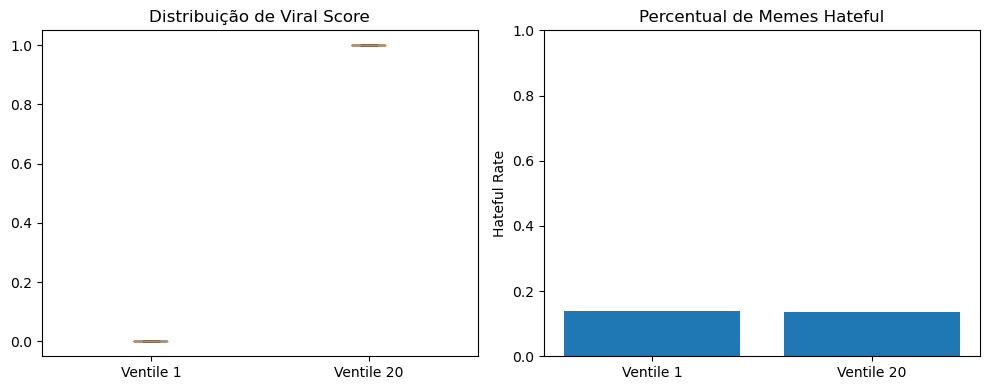

In [48]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].boxplot([res_v1["viral_q"], res_v20["viral_q"]],
                labels=["Ventile 1","Ventile 20"])
axes[0].set_title("Distribuição de Viral Score")

axes[1].bar(["Ventile 1","Ventile 20"], [h_rate_v1, h_rate_v20])
axes[1].set_ylim(0,1)
axes[1].set_ylabel("Hateful Rate")
axes[1].set_title("Percentual de Memes Hateful")

plt.tight_layout()
plt.show()

In [49]:
res_v1.to_csv("ventile_1_full_results.csv", index=False)
res_v20.to_csv("ventile_20_full_results.csv", index=False)

Salvos:
 - ventile_1_full_results.csv
 - ventile_20_full_results.csv
